In [2]:
#구글 코랩 mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

데이터 로드하기

In [3]:
#Training data
train = pd.read_csv("/content/drive/MyDrive/Euron 6기/train (1).csv")
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Testing data
test = pd.read_csv('/content/drive/MyDrive/Euron 6기/test.csv')
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


EDA

In [5]:
#Missing values in training set
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
#Missing values in test set
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [7]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
# A disaster tweet
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.values[1]

'Forest fire near La Ronge Sask. Canada'

In [10]:
#not a disaster tweet
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.values[1]

'I love fruits'

<Axes: xlabel='count', ylabel='keyword'>

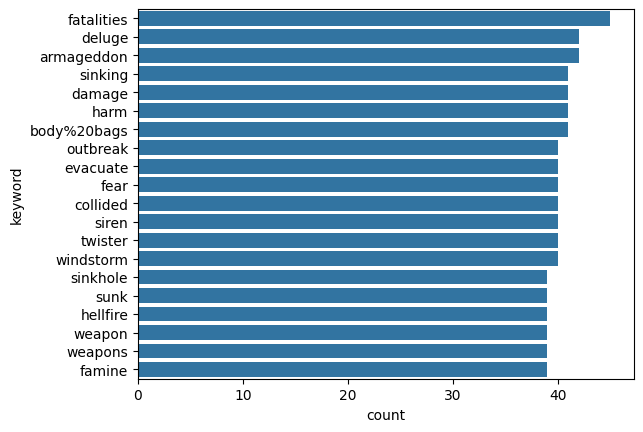

In [11]:
sns.barplot(y=train['keyword'].value_counts()[:20].index,x=train['keyword'].value_counts()[:20],
            orient='h')

In [12]:
train.loc[train['text'].str.contains('disaster', na=False, case=False)].target.value_counts()

target
1    102
0     40
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='location'>

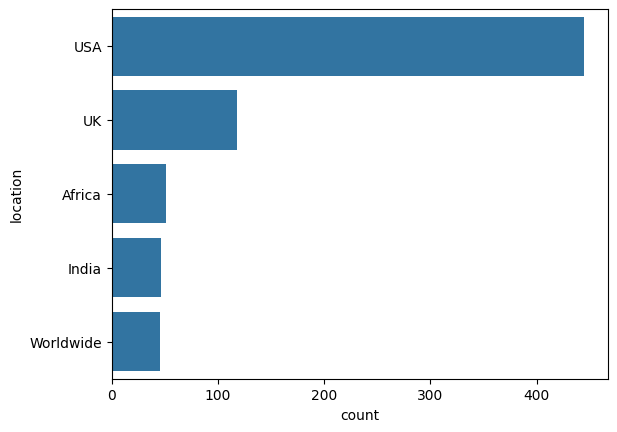

In [13]:
# Replacing the ambigious locations name with Standard names
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5],
            orient='h')

데이터 전처리

In [14]:
# A quick glance over the existing data
train['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [15]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

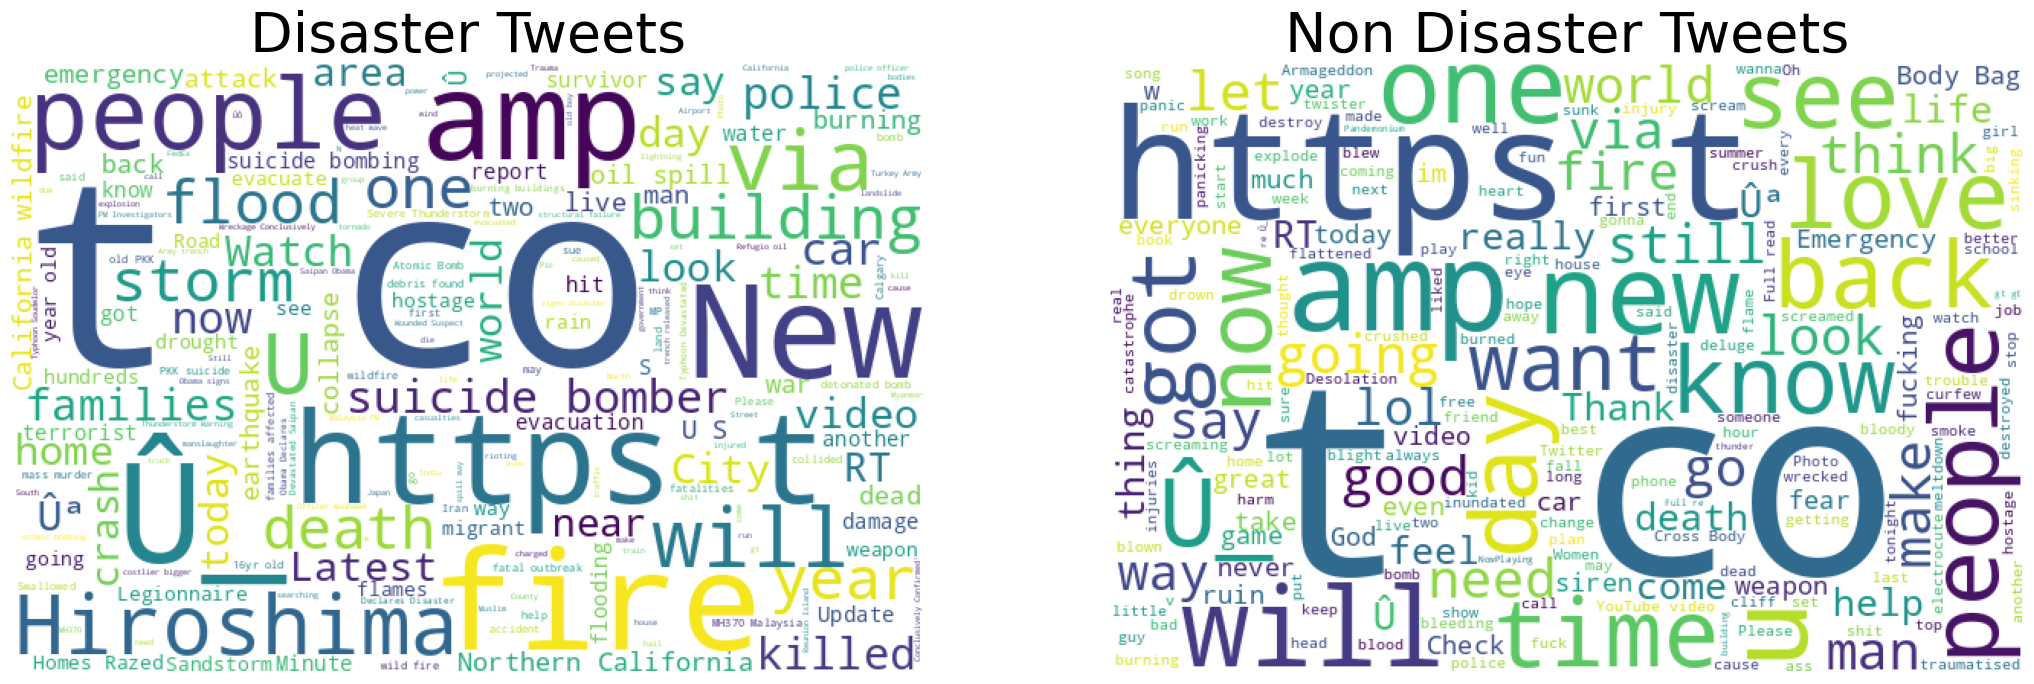

In [16]:
#워드 클라우드 생성
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

토큰화

In [17]:
text = "Are you coming , aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("Example Text: ",text)
print("------------------------------------------------------------------------------------------------")
print("Tokenization by whitespace:- ",tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer:- ",tokenizer2.tokenize(text))
print("Tokenization by punctuation:- ",tokenizer3.tokenize(text))
print("Tokenization by regular expression:- ",tokenizer4.tokenize(text))

Example Text:  Are you coming , aren't you
------------------------------------------------------------------------------------------------
Tokenization by whitespace:-  ['Are', 'you', 'coming', ',', "aren't", 'you']
Tokenization by words using Treebank Word Tokenizer:-  ['Are', 'you', 'coming', ',', 'are', "n't", 'you']
Tokenization by punctuation:-  ['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']
Tokenization by regular expression:-  ['Are', 'you', 'coming', 'aren', 't', 'you']


In [18]:
# Tokenizing the training and the test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

불용어 제거

In [21]:
import nltk
from nltk.corpus import stopwords

# NLTK의 stopwords 리소스 다운로드
nltk.download('stopwords')

def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    """
    words = [w for w in text.split() if w.lower() not in stopwords.words('english')]
    return " ".join(words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
# 리스트를 문자열로 변환
train['text'] = train['text'].apply(lambda x: ' '.join(x))
test['text'] = test['text'].apply(lambda x: ' '.join(x))

In [27]:
# stopwords 제거 적용
print(train.head())

   id keyword location                                               text  \
0   1     NaN      NaN  our deeds are the reason of this earthquake ma...   
1   4     NaN      NaN              forest fire near la ronge sask canada   
2   5     NaN      NaN  all residents asked to shelter in place are be...   
3   6     NaN      NaN  people receive wildfires evacuation orders in ...   
4   7     NaN      NaN  just got sent this photo from ruby alaska as s...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


Token normalization

In [29]:
import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

# NLTK의 WordNet 리소스 다운로드
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [30]:
# Stemming and Lemmatization examples
text = "feet cats wolves talked"

tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

# Stemmer
stemmer = nltk.stem.PorterStemmer()
print("Stemming the sentence: ", " ".join(stemmer.stem(token) for token in tokens))

# Lemmatizer
lemmatizer=nltk.stem.WordNetLemmatizer()
print("Lemmatizing the sentence: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))

Stemming the sentence:  feet cat wolv talk
Lemmatizing the sentence:  foot cat wolf talked


In [31]:
# After preprocessing, the text format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))
train['text']
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,o u r d e e d s a r e t h e r e a s o ...,1
1,4,NaN,NaN,f o r e s t f i r e n e a r l a r o n ...,1
2,5,NaN,NaN,a l l r e s i d e n t s a s k e d t o ...,1
3,6,NaN,NaN,p e o p l e r e c e i v e w i l d f i r e ...,1
4,7,NaN,NaN,j u s t g o t s e n t t h i s p h o t ...,1


In [32]:
# text preprocessing function
def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

임베딩

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
count_vectorizer = CountVectorizer(stop_words=None, token_pattern=r'\b\w+\b', min_df=1)
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test["text"])

## Keeping only non-zero elements to preserve space
print(train_vectors[0].todense())

[[8 0 0 2 8 2 1 4 2 0 1 4 1 1 4 0 1 5 4 3 3 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]]


TF-IDF 벡터화

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [46]:
test["text"]

0       j u s t   h a p p e n e d   a   t e r r i b l ...
1       h e a r d   a b o u t   e a r t h q u a k e   ...
2       t h e r e   i s   a   f o r e s t   f i r e   ...
3       a p o c a l y p s e   l i g h t i n g   s p o ...
4       t y p h o o n   s o u d e l o r   k i l l s   ...
                              ...                        
3258    e a r t h q u a k e   s a f e t y   l o s   a ...
3259    s t o r m   i n   r i   w o r s e   t h a n   ...
3260    g r e e n   l i n e   d e r a i l m e n t   i ...
3261    m e g   i s s u e s   h a z a r d o u s   w e ...
3262    c i t y o f c a l g a r y   h a s   a c t i v ...
Name: text, Length: 3263, dtype: object

In [45]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

ValueError: empty vocabulary; perhaps the documents only contain stop words

2시간 동안 오류 해결해보려 했는데 해결하지 못했습니다ㅜㅜ

Logistic Regression Classifier

In [40]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.5439408 , 0.52549697, 0.4822566 , 0.50697293, 0.5497076 ])

In [41]:
clf.fit(train_vectors, train["target"])

LogisticRegression()

In [42]:
# Fitting a simple Logistic Regression on TFIDF
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
scores

NameError: name 'train_tfidf' is not defined

Naives Bayes Classifier

In [47]:
# Fitting a simple Naive Bayes on Counts
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.54881266, 0.53344077, 0.53511706, 0.52194733, 0.5815261 ])

In [48]:
clf_NB.fit(train_vectors, train["target"])

MultinomialNB()

In [49]:
# Fitting a simple Naive Bayes on TFIDF
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

NameError: name 'train_tfidf' is not defined

XGBoost

In [50]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.49632353, 0.49066214, 0.51948052, 0.54070661, 0.5559906 ])

In [51]:
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

NameError: name 'train_tfidf' is not defined